# Dimensionality Reduction Of The NSCLC Dataset Using PCA And UMAP

In [1]:
# loading packages
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from umap import UMAP

/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

## Load data

Load the AnnData file that has been prepared in data_prep_NSCLC.

In [2]:
# define the path to the saved AnnData file
saved_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/2.NSCLC notebooks/adata_donor_1.h5ad"

# load the AnnData object from the HDF5 file
adata_donor_1 = sc.read_h5ad(saved_path)

/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Preprocessing

The data preprocessing steps align with Geneformer's recommendations for dimensionality reduction. Leveraging the Scanpy library, the code filters out cells expressing fewer than 10 genes and genes expressed in fewer than 10 cells. It then normalizes total counts, adjusting the expression values of each cell to a target sum of 10,000. Lastly, it employs a logarithmic transformation to stabilize gene variance.

In [3]:
# preprocess the AnnData object
sc.pp.filter_cells(adata_donor_1, min_genes=10)  
sc.pp.filter_genes(adata_donor_1, min_cells=10)    
sc.pp.normalize_total(adata_donor_1, target_sum=1e4)
sc.pp.log1p(adata_donor_1)  # als dit niet werkt: sc.pp.log1p(adata_donor_1.X)

In [4]:
# identify highly variable genes using Scanpy's function
sc.pp.highly_variable_genes(adata_donor_1, flavor="seurat", n_top_genes=2000)  # Adjust parameters as needed

# get the highly variable genes as a pandas DataFrame
highly_variable_genes_df = pd.DataFrame({
    "gene_name": adata_donor_1.var_names,
    "highly_variable": adata_donor_1.var["highly_variable"]
})

# filter the original DataFrame to keep only highly variable genes
highly_variable_gene_expression_df = adata_donor_1[:, adata_donor_1.var["highly_variable"]].to_df()


## PCA dimensionality reduction 2D

Next, the DataFrame containing highly variable gene expression data is converted into a dense array, ensuring compatibility with PCA, which typically requires dense matrices. The code then defines the number of principal components to retain, creates a PCA model, and fits it to the dense array. Finally, it transforms the data into a lower-dimensional space using PCA and stores the result in a DataFrame (reduced_df_2D), enabling visualization in a two-dimensionsal scatter plot.

In [5]:
# convert sparse elements to dense array
dense_array = np.array([x.toarray().ravel() if pd.api.types.is_sparse(x) else x for x in highly_variable_gene_expression_df.values])

# define the number of principal components to retain
n_components = 2  

# create PCA model and fit it to the dense array
pca_2D = PCA(n_components=n_components)
reduced_data_2D = pca_2D.fit_transform(dense_array)

# convert the result to a DataFrame
reduced_df_2D = pd.DataFrame(reduced_data_2D, columns=[f"PC{i}" for i in range(1, n_components + 1)])

In [6]:
# define the file path where you want to save the DataFrame
file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/reduced_df_2D_NSCLC.csv"

# save the DataFrame to a CSV file
reduced_df_2D.to_csv(file_path, index=False)

In [9]:
# create scatter plot 
fig = px.scatter(reduced_data_2D, x=0, y=1)

# update color of the scatter plot points
fig.update_traces(marker=dict(color='orange'))

# add title and axis labels
fig.update_layout(
    title="2D PCA of NSCLC cells",
    xaxis_title="PC1",
    yaxis_title="PC2",
)

fig.show()


## PCA dimensionality reduction to 256D

A PCA model with 256 principal components is applied to the dense array containing the expression data.
The resulting 256 principal components are then stored in a DataFrame which is saved to a CSV file, preserving the PCA-produced embeddings of the original data.

In [7]:
# create PCA model and fit it to the dense array
n_components_256 = 256
pca_256D = PCA(n_components=n_components_256)
reduced_data_256D = pca_256D.fit_transform(dense_array)

In [12]:
# convert the result to a DataFrame
reduced_df_256D = pd.DataFrame(reduced_data_256D, columns=[f"PC{i}" for i in range(1, n_components_256 + 1)])

# save the embeddings to a CSV file
embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/PCA_embeddings_NSCLC_256.csv"
reduced_df_256D.to_csv(embedding_file_path, index=False)

Visualise the PCA-reduced data in a 2D UMAP plot.

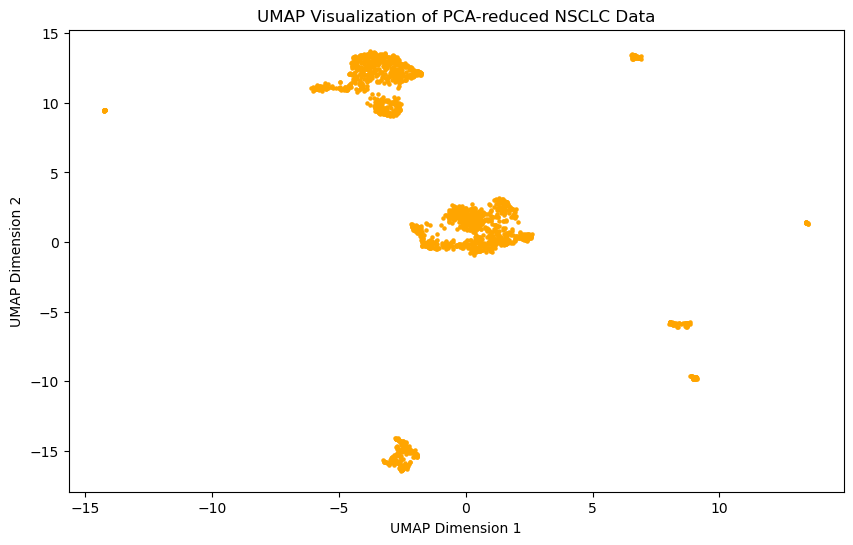

In [13]:
# apply UMAP
umap = UMAP(n_components=2)  
X_umap = umap.fit_transform(reduced_data_256D)

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5, color = "orange")
plt.title("UMAP Visualization of PCA-reduced NSCLC Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


The following code creates a scree plot. In PCA, eigenvalues represent the proportion of variance explained by each principal component, ranging from 0 to 1. A scree plot shows the eigenvalues of the principal components of a PCA. It is used to visually asses the amount of variance captured by each principal component.

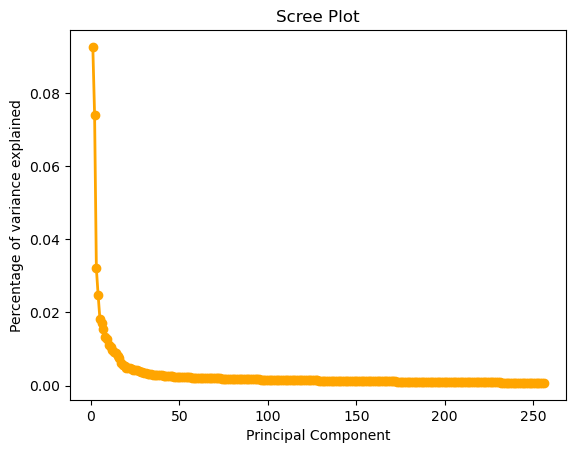

In [8]:
# plot a scree plot to visualize the eigenvalues

PC_values = np.arange(pca_256D.n_components_) + 1
plt.plot(PC_values, pca_256D.explained_variance_ratio_, "o-", linewidth=2, color="orange")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Percentage of variance explained")
plt.show()

In [13]:
# explained variance ratio for the first two principal components
print(pca_2D.explained_variance_ratio_)

[0.09257255 0.07403572]


## UMAP original dataset to 2D

This code segment applies UMAP to visualize the high-dimensional single-cell data from the provided AnnData object in a two-dimensional space, preserving both local and global structure. The resulting "umap_reduced_2" variable contains the coordinates for each data point in the reduced space, facilitating 2D visualization.

In [16]:
# UMAP original data to 2

# apply UMAP on adata
umap = UMAP(n_components=2)
umap_reduced_2 = umap.fit_transform(adata_donor_1.X)

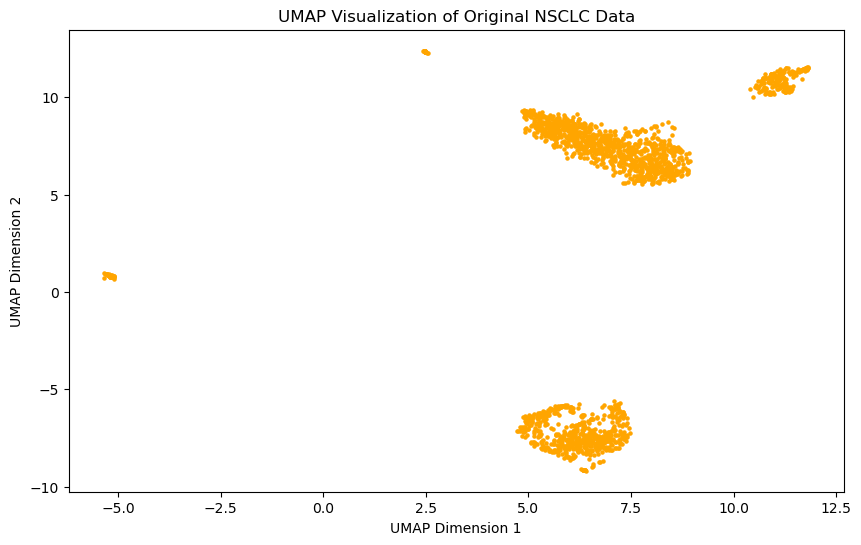

In [18]:
# visualize 
plt.figure(figsize=(10, 6))
plt.scatter(umap_reduced_2[:, 0], umap_reduced_2[:, 1], s=5, color = "orange")
plt.title("UMAP Visualization of Original NSCLC Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

## UMAP dimensionality reduction 256D

UMAP is applied to the original dataset to reduce the dimensionality to 256D. The resulting embeddings are saved to the specified path.

In [20]:
# UMAP original data to 256

# apply UMAP
umap = UMAP(n_components=256)
umap_reduced_256 = umap.fit_transform(adata_donor_1.X)

In [21]:
# create a DataFrame containing the UMAP embeddings
umap_embeddings_df = pd.DataFrame(umap_reduced_256, columns=[f"UMAP_{i}" for i in range(256)])

# save the embeddings to a CSV file
embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/UMAP_embeddings_NSCLC.csv"
umap_embeddings_df.to_csv(embedding_file_path, index=False)

      UMAP_0    UMAP_1     UMAP_2    UMAP_3    UMAP_4    UMAP_5    UMAP_6  \
0   3.902016 -0.603765   4.480237  7.096273  6.345993  4.796624  5.195304   
1   3.754045 -0.318926   4.391750  7.132579  6.457682  4.642372  5.358744   
2   8.561706  5.209134  10.651930  8.899673  6.442653  5.093894  5.576574   
3  10.011781  7.605016   6.664228  8.904128  6.955499  4.465858  5.671448   
4   8.419621  5.124164  10.441704  8.976316  6.485100  5.070034  5.721555   

     UMAP_7    UMAP_8    UMAP_9  ...  UMAP_246  UMAP_247  UMAP_248  UMAP_249  \
0  6.213552  8.128419  6.695556  ...  5.917202  5.269422  4.128417  4.639897   
1  5.892177  8.087961  6.658814  ...  5.874904  5.273900  4.118521  4.597682   
2  6.102921  7.970060  6.153395  ...  5.584076  5.383146  4.189991  4.555083   
3  6.048851  7.941005  6.101480  ...  5.624704  5.484687  4.037136  4.582389   
4  6.229168  7.970673  6.200574  ...  5.589869  5.273687  4.195647  4.560058   

   UMAP_250  UMAP_251  UMAP_252  UMAP_253  UMAP_254  UMA

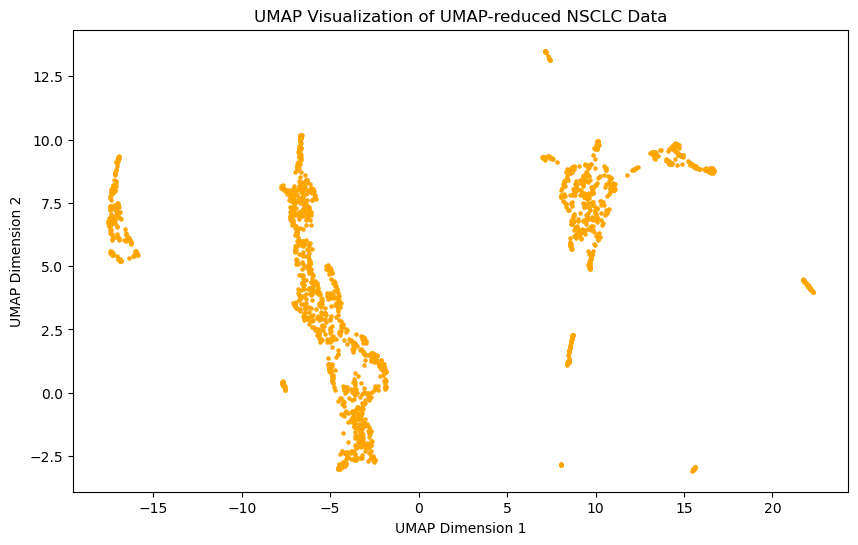

In [22]:
# apply UMAP 
umap = UMAP(n_components=2)  # You can choose 2 or 3 for visualization
umap_256 = umap.fit_transform(umap_reduced_256)

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(umap_256[:, 0], umap_256[:, 1], s=5, color = "orange")
plt.title("UMAP Visualization of UMAP-reduced NSCLC Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()
